In [1]:
# 1. Cài đặt và import thư viện
!pip install -q efficientnet
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16  # Changed from EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


2025-06-01 16:41:27.362235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748796087.550844      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748796087.605927      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Cấu hình
original_dir = "/kaggle/input/rice-leaf-disease-image"
output_dir = "dataset"
test_split = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
random.seed(42)

# Tách dữ liệu thành train_val và test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    images = os.listdir(class_path)
    random.shuffle(images)

    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]

    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(train_val_dir, class_name, img)
        )

print("✅ Đã tách dữ liệu thành công.")

Copying train_val images for Brownspot: 100%|██████████| 1280/1280 [00:07<00:00, 165.73it/s]

✅ Đã tách dữ liệu thành công.


In [3]:
# Kiểm tra cấu trúc dữ liệu
for root, dirs, files in os.walk(output_dir):
    print(root, ":", len(files), "files")

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())

print(f"Số lớp: {NUM_CLASSES}")
print(f"Số lượng ảnh train: {train_generator.samples}")
print(f"Số lượng ảnh validation: {val_generator.samples}")
print(f"Số lượng ảnh test: {test_generator.samples}")

dataset : 0 files
dataset/train_val : 0 files
dataset/train_val/Tungro : 1047 files
dataset/train_val/Blast : 1152 files
dataset/train_val/Bacterialblight : 1268 files
dataset/train_val/Brownspot : 1280 files
dataset/test : 0 files
dataset/test/Tungro : 261 files
dataset/test/Blast : 288 files
dataset/test/Bacterialblight : 316 files
dataset/test/Brownspot : 320 files
Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Số lớp: 4
Số lượng ảnh train: 3799
Số lượng ảnh validation: 948
Số lượng ảnh test: 1185


In [4]:
# Hàm tạo model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Fine-tuning: Mở khóa 4 khối cuối (block4 và block5)
for layer in vgg16_base.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_model = build_model(vgg16_base)
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("vgg16_rice_leaf_best.h5", monitor='val_loss', save_best_only=True, mode='min')

I0000 00:00:1748796251.741529      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Huấn luyện mô hình
vgg16_history = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748796264.677615     121 service.cc:148] XLA service 0x786524414980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748796264.678365     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748796265.199764     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/60 ━━━━━━━━━━━━━━━━━━━━ 23:59 24s/step - accuracy: 0.1719 - loss: 1.3898

I0000 00:00:1748796284.575928     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6635 - loss: 0.7952 - val_accuracy: 0.8914 - val_loss: 0.2945 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 882ms/step - accuracy: 0.9362 - loss: 0.1751 - val_accuracy: 0.9504 - val_loss: 0.1161 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 878ms/step - accuracy: 0.9715 - loss: 0.0786 - val_accuracy: 0.9715 - val_loss: 0.0703 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 881ms/step - accuracy: 0.9859 - loss: 0.0412 - val_accuracy: 0.9968 - val_loss: 0.0106 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 876ms/step - accuracy: 0.9921 - loss: 0.0223 - val_accuracy: 0.9958 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 862ms/step - accuracy: 0.9847 - loss: 0.0430 - val_accuracy: 0.9873 - val_loss: 0.0369 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 871ms/step - accuracy: 0.9938 

In [6]:
# Đánh giá mô hình trên tập validation
val_loss, val_acc = vgg16_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Đánh giá mô hình trên tập test
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 692ms/step - accuracy: 1.0000 - loss: 1.7664e-05
Validation Loss: 0.0000
Validation Accuracy: 1.0000
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 1.0000 - loss: 5.4635e-06
Test Loss: 0.0000
Test Accuracy: 1.0000


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step
Classification Report on Validation Set:
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       253
          Blast       1.00      1.00      1.00       230
      Brownspot       1.00      1.00      1.00       256
         Tungro       1.00      1.00      1.00       209

       accuracy                           1.00       948
      macro avg       1.00      1.00      1.00       948
   weighted avg       1.00      1.00      1.00       948

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       316
          Blast       1.00      1.00      1.00       288
      Brownspot       1.00      1.00      1.00       320
         Tungro       1.00      1.00      1.00       261

       accuracy                           1.00      1185
      macro avg       1.00      1.00      1.0

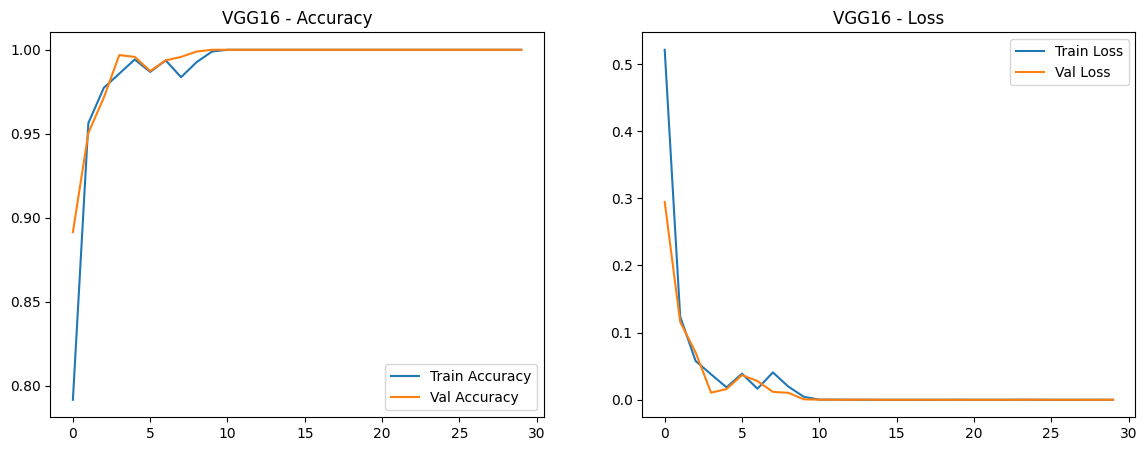

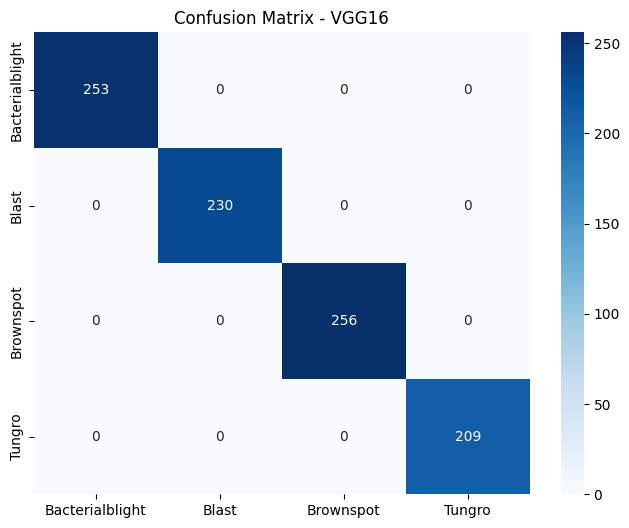

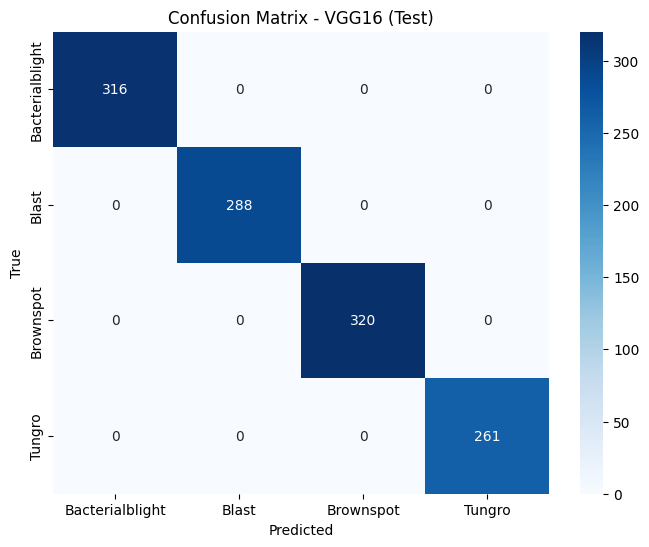

In [7]:
# Hàm vẽ biểu đồ lịch sử huấn luyện
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.savefig('training_history.png')

plot_history(vgg16_history, "VGG16")

# Đánh giá mô hình VGG16 trên tập validation
val_generator.reset()
vgg16_preds = vgg16_model.predict(val_generator)
vgg16_y_pred = np.argmax(vgg16_preds, axis=1)
vgg16_y_true = val_generator.classes

# Báo cáo phân loại
print("Classification Report on Validation Set:")
print(classification_report(vgg16_y_true, vgg16_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn
vgg16_conf_mat = confusion_matrix(vgg16_y_true, vgg16_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(vgg16_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - VGG16")
plt.savefig('confusion_matrix.png')

# Phần đánh giá mô hình trên tập test
test_generator.reset()  # Reset để đảm bảo thứ tự
test_preds = vgg16_model.predict(test_generator)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

# Báo cáo phân loại cho tập test
print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn cho tập test
test_conf_mat = confusion_matrix(test_y_true, test_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - VGG16 (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix_test.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test image path: dataset/test/Brownspot/BROWNSPOT5_044.jpg
True class: Brownspot
Predicted class: Brownspot
Confidence: 1.0000


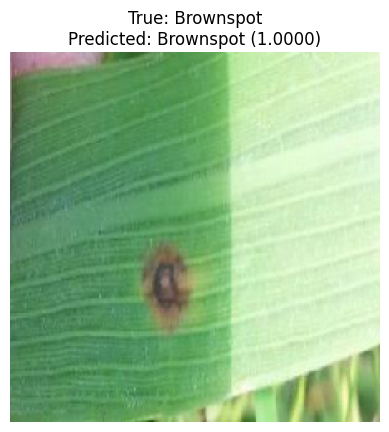

In [8]:
# Phần test ảnh ngẫu nhiên từ tập test
model = tf.keras.models.load_model('vgg16_rice_leaf_best.h5')

# Lấy danh sách tất cả ảnh trong tập test
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

# Chọn ngẫu nhiên một ảnh
test_img_path = random.choice(image_paths)

# Tải và xử lý ảnh test
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Dự đoán lớp
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Lấy nhãn thật từ đường dẫn
true_class = os.path.basename(os.path.dirname(test_img_path))

# Hiển thị kết quả
print(f"Test image path: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Hiển thị ảnh test
plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('test_result.png')

# Lưu mô hình
vgg16_model.save("vgg16_rice_final.h5")